In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
def metropolis_step(N, grid, J, beta=1.0):
    for _ in range(int(N/4)):
        i, j = np.random.randint(0, N, 2)
        current_vector = grid[i, j]
        new_angle = 2*np.pi*np.random.rand()
        new_vector = [np.cos(new_angle), np.sin(new_angle)]

        # Calculate energy change
        delta_E = 0
        delta_E -= J[i,j,0]*(np.dot(new_vector,grid[(i + 1) % N, j])-np.dot(current_vector,grid[(i + 1) % N, j]))
        delta_E -= J[i-1,j,0]*(np.dot(new_vector,grid[(i - 1) % N, j])-np.dot(current_vector,grid[(i - 1) % N, j]))
        delta_E -= J[i,j,1]*(np.dot(new_vector,grid[i, (j + 1) % N])-np.dot(current_vector,grid[i, (j + 1) % N]))
        delta_E -= J[i-1,j,1]*(np.dot(new_vector,grid[i, (j - 1) % N])-np.dot(current_vector,grid[i, (j - 1) % N]))

        # Metropolis criterion
        if delta_E < 0 or np.random.rand() < np.exp(-delta_E*beta):
            grid[i, j] = new_vector

    return grid


In [3]:
def plot_grid_orientations(grid, step, beta, filename_pattern):
    N = grid.shape[0]
    X, Y = np.meshgrid(range(N), range(N))
    U = grid[...,0]
    V = grid[...,1]

    plt.figure(figsize=(8, 8))
    plt.quiver(X, Y, U, V, pivot='middle')
    plt.title(f"Temperature {1/beta} Step {step}")
    plt.savefig(filename_pattern.format(beta, step))  # Save the plot as an image
    plt.close()  # Close the plot to free memory

In [4]:
# Modify your simulation loop to save images
image_folder = 'simulation_frames3'
os.makedirs(image_folder, exist_ok=True)
filename_pattern = os.path.join(image_folder, 'frame_{:02f}_{:04d}.png')

In [5]:
n = 5 #num of different J
N = 256  # Grid size
steps = 1000  # Number of simulation steps
m = 500 #num of thermalization
betas = [0.01, 0.1, 1, 10, 100, 1000]
history = np.zeros((n, len(betas), steps+1, N, N, 2), dtype='float32')
ods = np.zeros((n,len(betas), steps-m))
some_interval = 100



for k in range(n):
    #Initialize spin orientation.
    angle_grid = 2*np.pi*np.random.rand(N, N)
    grid = np.stack((np.cos(angle_grid), np.sin(angle_grid)), axis=-1)
    
    #Initialize spin-spin interaction coefficient.
    random_array = np.random.rand(N, N, 2)
    J = np.where(random_array < 0.5, -1, 1)

    for l in range(len(betas)):
        beta = betas[l]
        for h in range(steps):
            grid = metropolis_step(N, grid, J, beta)
            history[k, l, h, ...] = grid
            if h>m-1:
                ods[k,l,h-m] = np.mean(grid[...,0])

            # Plotting at selected steps
            if h % some_interval == 0 and k == 0:  # 'some_interval' is the frequency of steps at which you want to plot
                plot_grid_orientations(grid, h, beta, filename_pattern)



In [6]:
# After simulation, create a video
video_name = 'simulation_video3.mp4'
images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), 24, (width, height))

for image in sorted(images):
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

In [23]:
print(ods[4,1,1000])

-0.00440184349059736


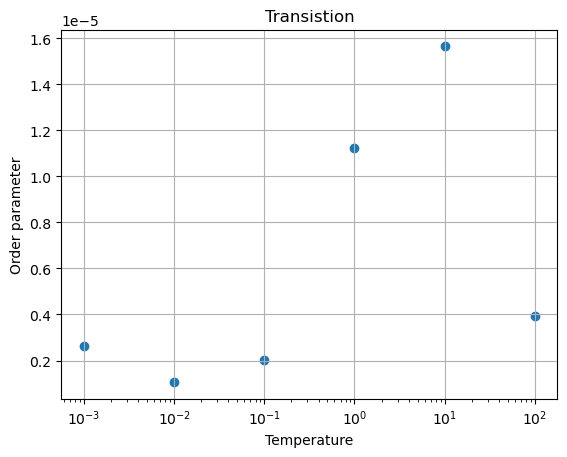

In [21]:
odt = np.mean(ods, axis=2)**2
odt = np.mean(odt, axis=0)
# Plotting the results
#plt.figure(figsize=(10, 6))
temperatures = [1/t for t in betas]
plt.scatter(temperatures, odt)
plt.xscale('log')
plt.xlabel('Temperature')
plt.ylabel('Order parameter')
plt.title('Transistion')
plt.grid(True)
plt.show()

In [26]:
def angle_correlation_function(N, grids, distance):
    total = 0

    # Loop over the entire grid
    for s in range(grids.shape[0]):
        roll_1 = np.roll(grids[s], shift=distance, axis=0)
        total += np.mean(np.sum(roll_1*grids[s], axis=2))
        roll_2 = np.roll(grids[s], shift=-distance, axis=0)
        total += np.mean(np.sum(roll_2*grids[s], axis=2))
        roll_3 = np.roll(grids[s], shift=distance, axis=1)
        total += np.mean(np.sum(roll_3*grids[s], axis=2))
        roll_4 = np.roll(grids[s], shift=-distance, axis=1)
        total += np.mean(np.sum(roll_4*grids[s], axis=2))
    return total/4/grids.shape[0]

distances = range(1, int(N/2),20)
ful_correlations = np.zeros((n, len(betas), len(distances)))
    
for k in range(n):
    for j in range(len(betas)):
        grids = history[k,j,-100:-1]
        correlations = [angle_correlation_function(N, grids, distance) for distance in distances]
        ful_correlations[k,j,...] = correlations
        print(1)


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [27]:
ful_correlations1 = np.mean(np.abs(ful_correlations), axis = 0)

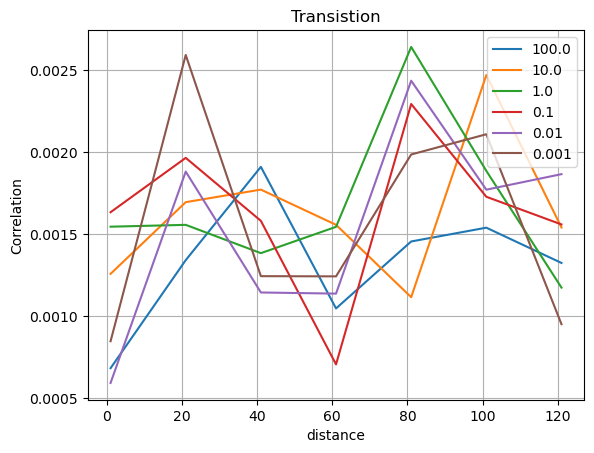

In [28]:
for k in range(len(betas)):
    plt.plot(distances, ful_correlations1[k], label=str(1/betas[k]))
plt.xlabel('distance')
plt.ylabel('Correlation')
plt.title('Transistion')
plt.grid(True)
plt.legend()
plt.show()